# **Predicting the perception of deprivation from VHR Satelite Images.**

## Intro

This code is developed by [**Taïs Grippa**](https://github.com/tgrippa) for the **PARTIMAP** project, based on the initial code of [**Eqi Luo**](https://github.com/EqiLuo/MappingDeprivation). 



## 0. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [1]:
import numpy as np
import os
import pandas as pd
import glob
import re
from tensorflow import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import sqlite3
import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import RandomCrop, RandomContrast
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K

Check the version of Tensorflow. It should be 2.7.0

In [4]:
print(tf.__version__)

2.7.0


Check the output of nvidia-smi utility to monitor the GPU usage.

In [5]:
! nvidia-smi

Fri Jan 28 12:02:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  Off  | 00000000:05:00.0  On |                  N/A |
| 24%   33C    P8    19W / 215W |   1107MiB /  7981MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Data preparation 

**In this part, we load, organize and transform all the input data to the format of input for deep learning model.**

### 1.1 Loading, structuring the data

In [456]:
# Define working path 
root = "/home/partimap/PARTIMAP_processing"
image_path = os.path.join(root, "partimap_wv3_rgb")
label_path = os.path.join(root, "partimap_ranking")
output_path = os.path.join(root, "output")
model_path = os.path.join(output_path, "model")
results_path = os.path.join(output_path, "results")

In [457]:
# Create directories if needed
list_directories = [output_path, model_path, results_path]
for path in list_directories:
    if not os.path.exists(path):
      os.makedirs(path)
      print("A new directory has been created (%s)"%path)
    else :
      print("The directory already exists (%s)"%path)

The directory already exists (/home/partimap/PARTIMAP_processing/output)
The directory already exists (/home/partimap/PARTIMAP_processing/output/model)
The directory already exists (/home/partimap/PARTIMAP_processing/output/results)


In [458]:
# Create a list of all the filenames of images
tile_list = [x for x in os.listdir(image_path) if x.endswith(".tif")]

# Sort the list naturally based on the number in the filename.
tile_list = natsorted(tile_list)

In [459]:
# Loop over and read all the images as numpy array, then stack them together 
rawimgsize = 333 #raw data size (333x333 pixel)
resizesize = 64 #resampling size (64x64 pixels)
stack = []
for tile in tile_list: 
    ds = gdal.Open(image_path + os.path.sep + tile)
    data = gdal_array.DatasetReadAsArray(ds, win_xsize=rawimgsize, win_ysize=rawimgsize, buf_xsize=resizesize, buf_ysize=resizesize) #resize (resample) raw data 
    data = np.transpose(data,(1,2,0)) #swap the axises to make the number of bands as the final dimension. 
    stack.append(data)

# Now, change the list into numpy array 
stack = np.array(stack)
print(stack.shape)

(2048, 64, 64, 3)


In [460]:
# check the datatype of the loaded numpy arrray
print(stack.dtype)

float32


In [461]:
stack[0,:,:,0]

array([[165., 163., 187., ..., 135., 230., 159.],
       [145., 153., 154., ...,  87.,  96.,  87.],
       [132., 145., 168., ..., 101.,  52.,  37.],
       ...,
       [225., 219., 315., ...,  83., 101.,  65.],
       [312., 322., 311., ..., 138., 147.,  71.],
       [114., 143., 133., ...,  95., 138.,  73.]], dtype=float32)

In [462]:
def standardize(image_data):
    image_data -= np.mean(image_data, axis=0)
    image_data /= np.std(image_data, axis=0)
    return image_data

def norm_01(image_data):
    image_data -= np.min(stack)
    image_data /= (np.max(stack) - np.min(stack))
    return image_data

stack = standardize(stack)
#stack = norm_01(stack)
print(stack.shape)

(2048, 64, 64, 3)


In [463]:
stack[0,:,:,0]

array([[-0.00574766, -0.02170146,  0.20056412, ..., -0.32934722,
         0.5796918 , -0.08021856],
       [-0.19640598, -0.13910507, -0.13364431, ..., -0.7902294 ,
        -0.6776096 , -0.78980124],
       [-0.3339073 , -0.22058176, -0.00789004, ..., -0.6574447 ,
        -1.0702347 , -1.2271212 ],
       ...,
       [ 0.50031376,  0.44788963,  1.2777079 , ..., -0.77544606,
        -0.64370185, -0.95028996],
       [ 1.339358  ,  1.4498733 ,  1.3427808 , ..., -0.3014063 ,
        -0.20599216, -0.9651088 ],
       [-0.52867883, -0.25551838, -0.33514515, ..., -0.72944707,
        -0.28641632, -0.8787914 ]], dtype=float32)

In [464]:
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
    a = np.ndarray(image_data.shape, dtype='float32')  
    a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
    a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
    a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
    if BGR2RGB: 
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


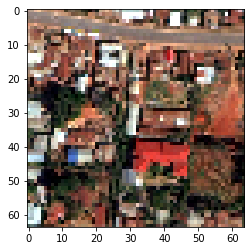

In [465]:
plt.imshow(Norma_Xpercentile(stack[0,:,:,]))

**Load the labels from SQLite and store it in numpy serie** 

In [466]:
# Load the labels stored in sqlite database into a pandas DataFrame
con = sqlite3.connect(os.path.join(label_path,"ranks_v1.sqlite"))
query = 'SELECT "index", CAST(photo_id as INT) AS photo_id, value FROM p2b ORDER BY photo_id'
df_labels = pd.read_sql_query(query, con) # perception results are stored in table 'p2b'
# Verify that result of SQL query is stored in the dataframe
print(df_labels.head())
con.close()

   index  photo_id      value
0      0         1  27.551694
1   1111         2  29.342712
2   1271         3  26.667648
3   1382         4  30.180472
4   1493         5  26.087409


In [467]:
# Standardise the labels in the range [0-1] (Min-Max normalisation)
df_labels['norm_value'] = (df_labels.loc[:,'value']-df_labels.loc[:,'value'].min())/(df_labels.loc[:,'value'].max()-df_labels.loc[:,'value'].min())
print(df_labels.head())
print('Min = %s'%round(df_labels.loc[:,'norm_value'].min(),5))
print('Max = %s'%round(df_labels.loc[:,'norm_value'].max(),5))

   index  photo_id      value  norm_value
0      0         1  27.551694    0.653658
1   1111         2  29.342712    0.722340
2   1271         3  26.667648    0.619756
3   1382         4  30.180472    0.754467
4   1493         5  26.087409    0.597505
Min = 0.0
Max = 1.0


In [468]:
# Extract the values of perception score and covert it to a 1-d array 
scores = df_labels.loc[:,'norm_value'].values

In [469]:
# Now we need to reshape the 1-d array to a 2-d array 
scores = scores.reshape(scores.size,-1)

# Check the shape and datatype of reference data
print(scores.shape)
print(scores.dtype)
print(scores)

(2048, 1)
float64
[[0.65365782]
 [0.72234038]
 [0.61975611]
 ...
 [0.59990736]
 [0.6555469 ]
 [0.72110724]]


In [470]:
# Before splitting the training and test dataset, let's check again the shape of x and y. 
print(stack.shape)
print(scores.shape)

(2048, 64, 64, 3)
(2048, 1)


In [471]:
# Check if labels and images ID match
set_images = set([int(os.path.splitext(x)[0].split("_")[-1]) for x in tile_list])
set_label = set(df_labels.loc[:,'photo_id'].values.tolist())
missing_label = list(sorted(set_images - set_label))
missing_image = list(sorted(set_label - set_images))
if missing_label or missing_image: 
    print('Label(s) ID missing:', missing_label)
    print('Image(s) ID missing:', missing_image)
else: 
    print('Labels and images ID match perfectly') 

Labels and images ID match perfectly


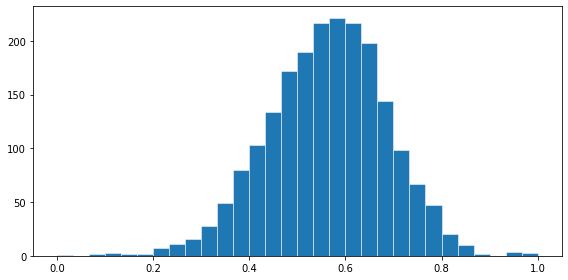

In [472]:
# print the distribution of target variables (y)
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(scores, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

### 1.2 Splitting the input data

**Now, we split the input data into training+validation and test datasets.**

the proportion of training+validation and test follows the rule of thumb, 70% vs 30%.

In [473]:
# Split the inputs. Note that variable 'stack' is the X (imagery), and variable 'score' is the Y (labels).  
x_train, x_val, y_train, y_val = train_test_split(
    stack, scores, test_size = 0.3, random_state = 65) # specify the random state to ensure replicable output across multiple function calls.

# Check the shape of each sub-dataset 
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1433, 64, 64, 3)
(1433, 1)
(615, 64, 64, 3)
(615, 1)


## 2. Deep CNN-based Regression Model 

In this part, we build a VGG-like model to predict the deprivation degree.

The CNN model has 4 convolution blocks and 3 fully connected layers. The details were presented below

### 2.1 Models Architecture Definition

**VGG**

In [474]:
# Input shape 
#input_shape = (256, 256, 3)
#input_shape = (128, 128, 3)
input_shape = (64, 64, 3)

In [539]:
## VGG-like (12 layers) regression model

def VGG_model():
    model = Sequential()
        
    # block 1 
    model.add(Conv2D(64, (3, 3), padding='same', name = 'block1_conv1', input_shape=input_shape)) #block1_conv1
    model.add(BatchNormalization(axis=-1, name = 'block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', name = 'block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name = 'block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'block1_pool')) #block1_pool
    
    # block 2 
    model.add(Conv2D(128, (3, 3), padding='same', name = 'block2_conv1')) #block2_conv1
    model.add(BatchNormalization(axis=-1, name = 'block2_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same', name = 'block2_conv2')) #block2_conv2
    model.add(BatchNormalization(axis=-1, name = 'block2_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'block2_pool')) #block2_pool
    
    # block 3 
    model.add(Conv2D(256, (3, 3), padding='same', name = 'block3_conv1')) #block3_conv1
    model.add(BatchNormalization(axis=-1, name = 'block3_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', name = 'block3_conv2')) #block3_conv2
    model.add(BatchNormalization(axis=-1, name = 'block3_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', name = 'block3_conv3')) #block3_conv3
    model.add(BatchNormalization(axis=-1, name = 'block3_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'block3_pool')) #block3_pool
    
    # block 4 
    model.add(Conv2D(512, (3, 3), padding='same', name = 'block4_conv1')) #block4_conv1
    model.add(BatchNormalization(axis=-1, name = 'block4_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', name = 'block4_conv2')) #block4_conv2
    model.add(BatchNormalization(axis=-1, name = 'block4_bn2'))
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', name = 'block4_conv3')) #block4_conv3
    model.add(BatchNormalization(axis=-1, name = 'block4_bn3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = 'block4_pool')) #block4_pool

    # Now to configure the fully conneceted layers 
    
    # FC1
    model.add(Flatten())
    model.add(Dense(512, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25, name = 'fc1_drop1')) 
    
    # FC2
    model.add(Dense(256, name = 'fc2'))
    model.add(BatchNormalization(axis=-1, name = 'fc2_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5, name = 'fc2_drop1'))
    
    # Regression layer 
    model.add(Dense(1, activation = 'sigmoid', name = 'regression'))
    return model
    
model = VGG_model()
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 64, 64, 64)       256       
 ion)                                                            
                                                                 
 activation_204 (Activation)  (None, 64, 64, 64)       0         
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 64, 64, 64)       256       
 ion)                                                            
                                                                 
 activation_205 (Activation)  (None, 64, 64, 64)     

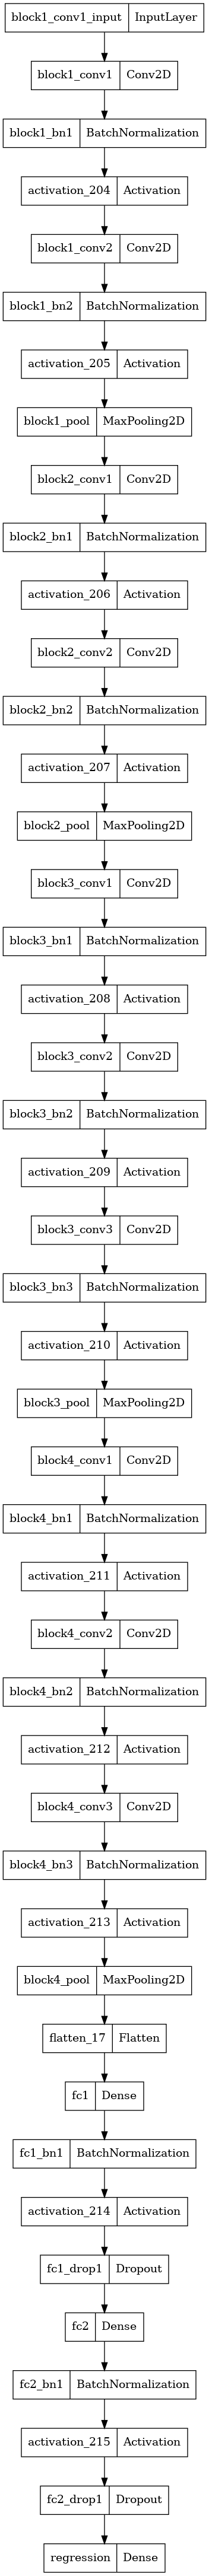

In [540]:
# Plot model architecture
plot_model(model, to_file=os.path.join(model_path,'VGG_model.png'))

**InceptionV3**

### 2.2 Data Augmentation Definition

In [541]:
# Set Image Data Generator
datagen = ImageDataGenerator(
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='reflect'
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


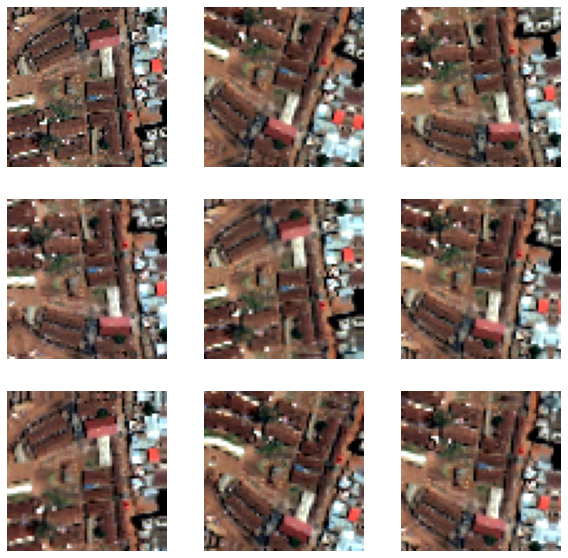

In [542]:
# Visualize the augmented data for an original image (in top left corner)
img_idx = 154
pic = datagen.flow(np.expand_dims(x_train[img_idx], axis=0), batch_size =1)
plt.figure(figsize=(10, 10))
for i in range(9):
    if i==0:
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(Norma_Xpercentile(x_train[img_idx]))
        plt.axis("off")
    else:
        ax = plt.subplot(3, 3, i + 1)
        batch = pic.next()
        plt.imshow(Norma_Xpercentile(batch[0]))
        plt.axis("off")

### 2.3 Setting up the model

In [543]:
# Adam was applied as the optimizer for this model, with learning rate at 0.XXXX1 
#opt = Adam(learning_rate=1e-4, decay=1e-4/100)
opt = Adam(learning_rate=1e-3)

In [544]:
# Specify the R2 calculation formula to use as an assessment metric. 
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [545]:
# Compilation of the model, loss function = MAE
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination]) 

In [546]:
# Using checkpoint callback fucntion to save the weights that yield the best result on validation dataset. 
checkpoint_filepath = os.path.join(output_path,'model','VGG_mae_best_performed_model.hdf5')
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

In [547]:
# Using 'Reduce LR on Plateau' function to let the model take smaller steps when the loss value hold on, and eventually maybe found a better optima.
#Reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=20, verbose=1, mode='auto', cooldown=0, min_lr=0)

### 2.4 Training the model

Note that the batch size was set to 128 after hyper-parameter tuning. 

Within the 'training+validation' datasets, 70% were used to train the model and 30% were used for validation. 


In [548]:
# Define hyperparameter
bsize = 128
nb_epochs = 100

# Train the model 
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=bsize),
    steps_per_epoch=int(len(x_train)/bsize),
    validation_data = (x_val,y_val),
    epochs = nb_epochs, 
    callbacks = [checkpoint])

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.2030 - mean_absolute_error: 0.2030 - root_mean_squared_error: 0.2622 - coeff_determination: -3.6571
Epoch 00001: val_mean_absolute_error improved from inf to 0.55888, saving model to /home/partimap/PARTIMAP_processing/output/model/VGG_mae_best_performed_model.hdf5
11/11 [==============================] - 6s 377ms/step - loss: 0.2030 - mean_absolute_error: 0.2030 - root_mean_squared_error: 0.2622 - coeff_determination: -3.6571 - val_loss: 0.5589 - val_mean_absolute_error: 0.5589 - val_root_mean_squared_error: 0.5728 - val_coeff_determination: -22.3260
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.1448 - mean_absolute_error: 0.1448 - root_mean_squared_error: 0.1937 - coeff_determination: -1.5042
Epoch 00002: val_mean_absolute_error improved from 0.55888 to 0.44110, saving model to /home/partimap/PARTIMAP_processing/output/model/VGG_mae_best_performed_model.hdf5
11/11 [=========================

### 2.5 Visualizing the training history  
In this part, we plot the loss curve and metric curve

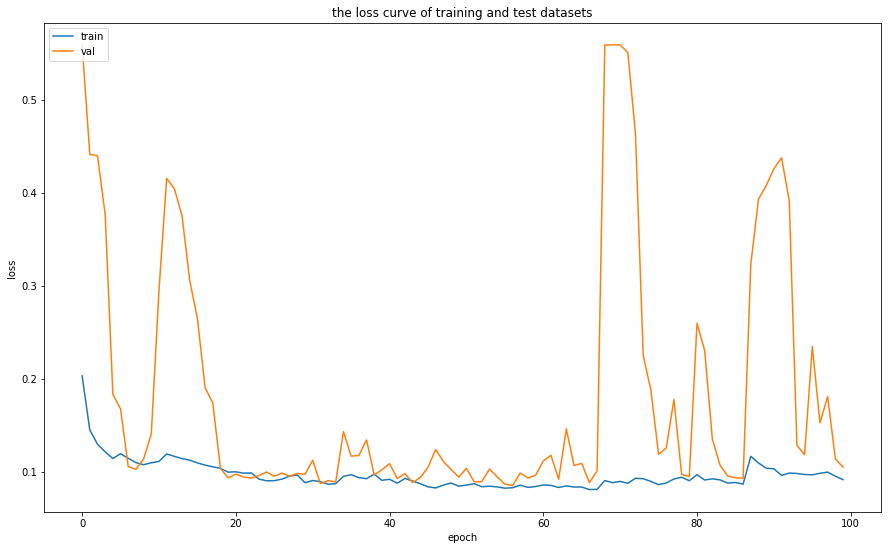

In [549]:
# plot model training history

fig = plt.subplots(figsize=(15, 9))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("the loss curve of training and test datasets")
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel("loss")
plt.xlabel("epoch")

plt.savefig(os.path.join(results_path,'mae_loss.png'), dpi = 300)
plt.show()

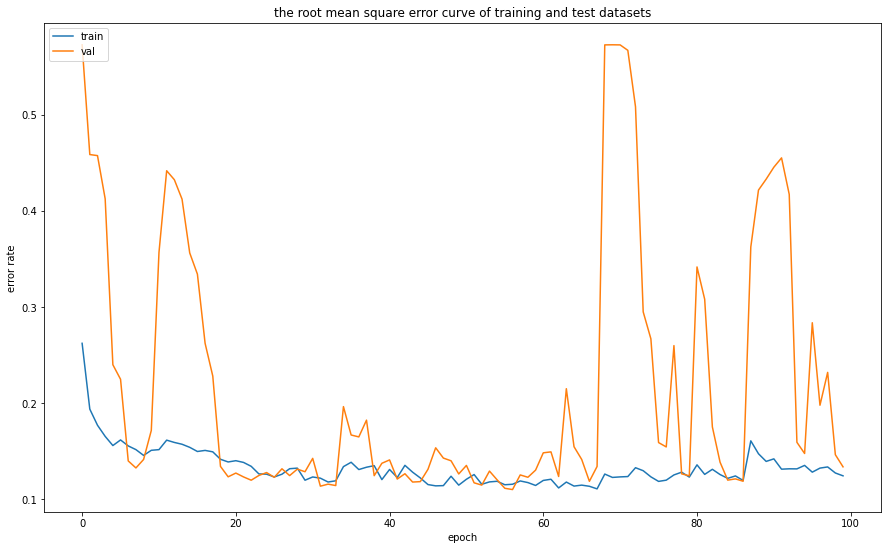

In [550]:
fig = plt.subplots(figsize=(15, 9))
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("the root mean square error curve of training and test datasets")
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel("error rate")
plt.xlabel("epoch")

plt.savefig(os.path.join(results_path,'mae_rmse.png'), dpi = 300)
plt.show()

## 3. Assessing the model performance on test datasets

### 3.1 Save and configure the model with best performance 

In this step, we will configure the model by reloading the weights of best performance through training, and apply it on both the training and validation datasets. The scatter plots will be created to evaluate the model prediction by comparing training and validation datasets, to see if there are over-/under-estimation or over-fitting etc. 

In [551]:
# Load best 
best_model = VGG_model()
best_model.load_weights(checkpoint_filepath)

### 3.2 Applying the model on validation datasets 

In [552]:
# run the model on the train and test datasets 
y_pred_val = best_model.predict(x_val) 
y_pred_train = best_model.predict(x_train)

In [553]:
# calculate the R2 Score and RMSE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

R2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train,squared=False) 
mae_train = mean_absolute_error(y_train, y_pred_train)

print("the R2 of training dataset is: %0.4f" %R2_train)
print("the RMSE of training dataset is: %0.4f" %rmse_train)
print("the MAE of training dataset is: %0.4f" %mae_train)

R2_val = r2_score(y_val,y_pred_val)
rmse_val = mean_squared_error(y_val, y_pred_val,squared=False) 
mae_val = mean_absolute_error(y_val, y_pred_val) 

print("the R2 of validation dataset is: %0.4f" %R2_val)
print("the RMSE of validation dataset is: %0.4f" %rmse_val)
print("the MAE of validation dataset is: %0.4f" %mae_val)

the R2 of training dataset is: 0.2878
the RMSE of training dataset is: 0.1047
the MAE of training dataset is: 0.0805
the R2 of validation dataset is: 0.2315
the RMSE of validation dataset is: 0.1099
the MAE of validation dataset is: 0.0852


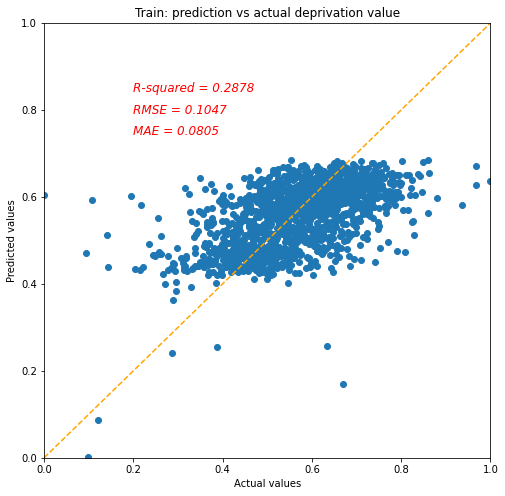

In [554]:
fig = plt.figure(figsize=(8,8)) 
ax=plt.subplot(1,1,1) 
ax.scatter(y_train, y_pred_train)  
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), c = 'orange', linestyle='--')
ax.set_title("Train: prediction vs actual deprivation value")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted values")
ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])

ax.text(0.2, 0.85, "R-squared = %0.4f" % R2_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.8, "RMSE = %0.4f" % rmse_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.75, "MAE = %0.4f" % mae_train, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')

plt.savefig(os.path.join(results_path,'mae_train.png'), dpi = 300)
plt.show()

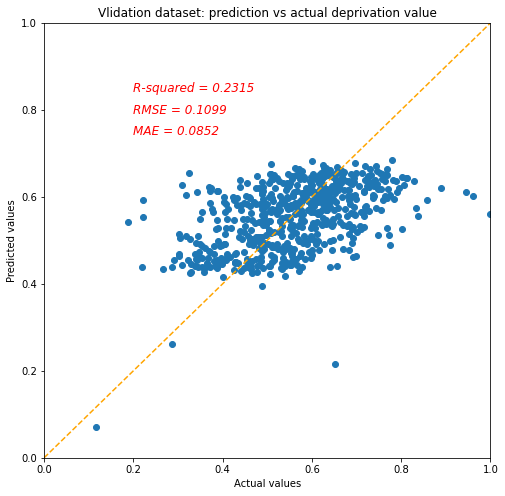

In [555]:
fig = plt.figure(figsize=(8,8)) 
ax=plt.subplot(1,1,1) 
ax.scatter(y_val, y_pred_val)  
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), c = 'orange', linestyle='--')
ax.set_title("Vlidation dataset: prediction vs actual deprivation value")
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted values")
ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])

ax.text(0.2, 0.85, "R-squared = %0.4f" % R2_val, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.8, "RMSE = %0.4f" % rmse_val, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')
ax.text(0.2, 0.75, "MAE = %0.4f" % mae_val, fontsize=12, color = "r", style = "italic", weight = "light", verticalalignment='center', horizontalalignment='left')

plt.savefig(os.path.join(results_path,'mae_val.png'), dpi = 300)
plt.show()